# generated the data from solver for taining the data driven

In [ ]:

import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

import os 
# @partial(jit, static_argnums=(0,))
def allen_cahn_equation(uk, pp2, qq2, dt, eps, Nt):

    cahn = eps**2
    samples_timesteps = []

    for iter in range(1, Nt+1):
        uk = jnp.real(uk)
        # print(f'uk ko size inside the loop:{uk.shape}')

        # Compute denominator in Fourier space
        denominator = cahn + dt * (2 + cahn * (pp2 + qq2))

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 

        v_hat = s_hat / denominator  # Now shapes should match


        uk = jfft.ifft2(v_hat)  # inverse FFT
        uk = jnp.real(uk)
        if iter % 4000 == 0:
            samples_timesteps.append(uk)
    # print(f'uk ko size:(uk.shape)')
        # Return the real part
    return jnp.array(samples_timesteps)  # Return only the real part
    





# difinning the no of grid points in x, y and z
Nx = 28 # number of grid points in x be positive even integer number
Ny = 28 # number of grid points in y be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

epsillon = 0.5 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# theta = jnp.arctan2(yy, xx)
#   # or another appropriate value
# uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * epsillon))
data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
print(f'data ko size:{data.shape}')

# Select 1,000 random samples
key = jax.random.PRNGKey(0)  # Random seed for reproducibility
idx = jax.random.choice(key, data.shape[0], shape=(50,), replace=False)  # Random 1k indices
input_samples = data[idx]  # Shape: (1000, Nx, Ny)
print(f'input_sample ko size :{input_samples.shape}')


# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)


input_samples= input_samples.reshape(-1, Nx , Ny)
print(f'input_sample ko size :{input_samples.shape}')

samples = []

for uk in input_samples:
   
    ac_input = allen_cahn_equation(uk, pp2, qq2, dt, epsillon, Nt)
# print(f'shape of ac_input:{ac_input.shape}')
    samples.append(ac_input)
samples = jnp.array(samples)
print(f'samples ko shape:{samples.shape}')
      

# # Specify the directory where y want to save the data
# save_dir = './data_driven/data'

#     # Ensure the directory exists, create it if not
# os.makedirs(save_dir, exist_ok=True)



In [ ]:
# # Specify the directory where y want to save the data
save_dir = './data_driven/data'

    # Ensure the directory exists, create it if not
os.makedirs(save_dir, exist_ok=True)
# Save the training and testing data
# print("Saving training data to u_train.npy...")
np.save(os.path.join(save_dir, "driven_data_28x28_1k_input_samples_next1ksteps.npy"), np.array(input_samples))
np.save(os.path.join(save_dir, "driven_data_28x28_1k_40timesteps_next1k.npy"), np.array(samples))

In [5]:
import os
# # Specify the directory where y want to save the data
save_dir = './data_driven/data'

    # Ensure the directory exists, create it if not
os.makedirs(save_dir, exist_ok=True)
loaded_input_samples = np.load(os.path.join(save_dir, "driven_data_28x28_1k_input_samples.npy"))
print(f'loaded_input_samples ko shape:{loaded_input_samples.shape}')

loaded_samples = np.load(os.path.join(save_dir, "driven_data_28x28_1k_11timestep.npy"))
print(f'loaded_samples ko shape:{loaded_samples.shape}')

loaded_input_samples ko shape:(1000, 28, 28)
loaded_samples ko shape:(1000, 11, 28, 28)


# plot the data 

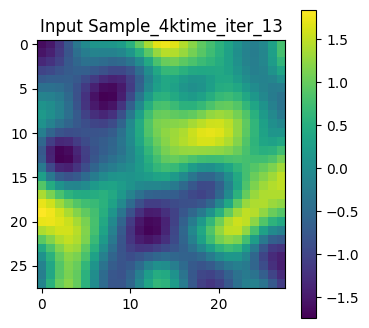

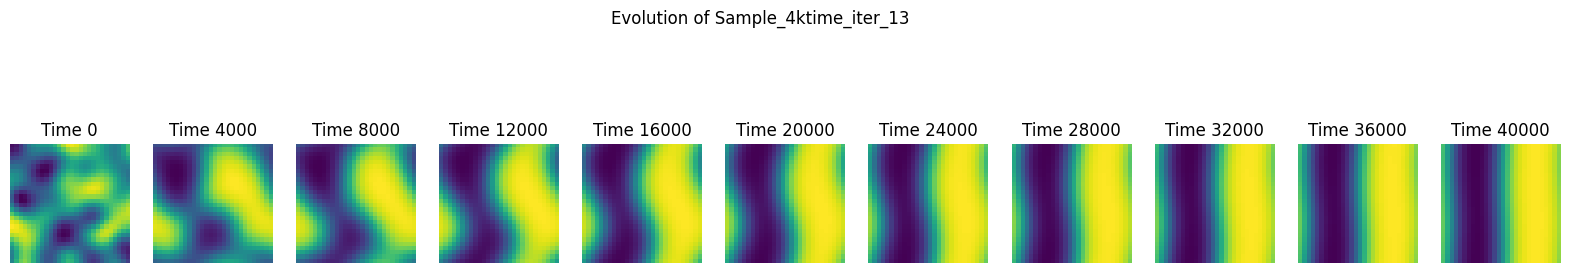

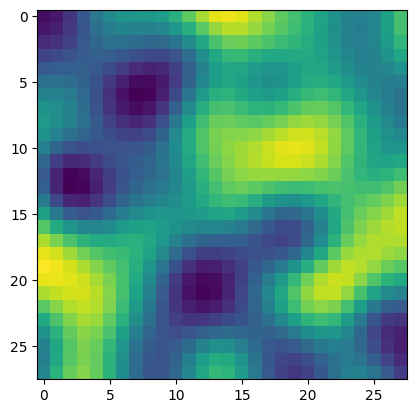

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt

save_dir = './data_driven'

# Choose a sample index
sample_idx = 13

# Define the directory
plot_save_dir = os.path.join(save_dir,  "data_driven_plot")

# Create the directory if it doesn't exist
os.makedirs(plot_save_dir, exist_ok=True)


# Plot input data
plt.figure(figsize=(4, 4))
plt.imshow(loaded_input_samples[sample_idx], cmap='viridis')
plt.colorbar()
plt.title(f'Input Sample_4ktime_iter_{sample_idx}')
plt.savefig(os.path.join(plot_save_dir, f'input_sample_4ktime_iter_{sample_idx}.png')) 
plt.show()


# Choose a sample index
sample_idx = 13

fig, axes = plt.subplots(1, 11, figsize=(20, 4))  # 11 time steps

for t in range(11):
    axes[t].imshow(loaded_samples[sample_idx, t], cmap='viridis')
    axes[t].set_title(f'Time {t * 4000}')
    axes[t].axis('off')

plt.suptitle(f'Evolution of Sample_4ktime_iter_{sample_idx}')
plt.savefig(os.path.join(plot_save_dir, f'Evolution_sample_4ktime_iter_{sample_idx}.png'))
plt.show()



import matplotlib.animation as animation

fig, ax = plt.subplots()
im = ax.imshow(loaded_samples[sample_idx, 0], cmap='viridis')

def update(frame):
    im.set_array(loaded_samples[sample_idx, frame])
    ax.set_title(f'Time Step: {frame * 4000}')
    return im,

ani = animation.FuncAnimation(fig, update, frames=11, interval=500)

# ani.save(evolution_animation.gif', writer='pillow')  # Save as GIF
plt.show()


## copy required code from model training, here we are calculating the data driven loss

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pickle




# # saving the parameter
def save_model(model, filename):
    # Save model parameters, architecture and optimizer state
    save_dict = {
        'arch': model.arch,
        'N': model.N,
        'lr': model.lr,
        'eps': model.eps,
        'pp2': model.pp2,
        'qq2': model.qq2,
        'dt': model.dt,
        'L': model.L,
        'h': model.h,
        'x': model.x,
        'y': model.y,
        'params': jax.device_get(model.get_params(model.opt_state)),
        'train_losses': model.train_losses,
        'test_losses': model.test_losses,
        'opt_state': jax.device_get(model.opt_state),  # Save optimizer state too
    }

    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)

def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __len__(self):
        return self.N//self.batch_size
       
        
        

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        
        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
        # print("Denominator shape:", denominator.shape)

        # Expand the denominator to match the shape of s_hat (28, 28, 1)
        denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
        # print("Denominator shape after expansion:", denominator.shape)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        # print("Shape of s_hat (after fft2):", s_hat.shape)

        v_hat = s_hat / denominator  # Now shapes should match
        # print("Shape of v_hat (after division):", v_hat.shape)

        uk = jfft.ifft2(v_hat)  # inverse FFT
        # print("Shape of uk (after ifft2):", uk.shape)

        uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
        # print("Shape of uk after reshaping:", uk.shape)

        # Return the real part
        return jnp.real(uk)  # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, batch_input, batch_label):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, batch_input) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
       
        datadriven_loss = jnp.mean((batch_label - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch_input, batch_label):
        # print(f'vmap agadi :{batch_input.shape, batch_label.shape}')
       
        batch_loss = vmap(self.loss_single, (None, 0, 0))(params, batch_input, batch_label)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch_input, batch_label):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, batch_input, batch_label)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, datatrain_input, datatrain_label,  datatest_input, datatest_label, nIter=10000):
        datainput_train_iter = iter(datatrain_input)
        datatrain_label_iter = iter(datatrain_label)
        pbar = trange(nIter)  # Progress bar for total iterations



        for it in pbar:
            batch_input_train = next(datainput_train_iter)
            batch_label_train= next(datatrain_label_iter)
            batch_input_train = jnp.array(batch_input_train)
            batch_label_train = jnp.array(batch_label_train)
            
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch_input_train, batch_label_train)


            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss_train = self.loss_batches(params, batch_input_train, batch_label_train)
                self.train_losses.append(loss_train)


                # for testing
                test_loss = []
                for _ in range(len(datatest_input)):
                    datatest_input_iter= iter(datatest_input)
                    datatest_label_iter= iter(datatest_label)
                    batch_input_test = next(datatest_input_iter)
                    batch_label_test= next(datatest_label_iter)
                    batch_input_test = jnp.array(batch_input_test)
                    batch_label_test = jnp.array(batch_label_test)


                    test_batch_loss = self.loss_batches(params, batch_input_test, batch_label_test)
                    test_loss.append(test_batch_loss)
                
                mean_test_loss = jnp.mean(jnp.array(test_loss))
                    
                self.test_losses.append(mean_test_loss)
            pbar.set_postfix({'train Loss': loss_train, 'test loss': mean_test_loss})


    def pred(self, data_test, data_label):
        # uk_solver_list = []
        uk_nnetwork_list = []
        

        for item in data_test:

            # uk = self.allen_cahn_equation(item)
            # cahn = eps**2
            # uk = jnp.real(item)
           

            # # Compute denominator in Fourier space
            # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # # Perform FFT calculations
            # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            # v_hat = s_hat / denominator  
            # uk_ac = jfft.ifft2(v_hat)  
            # uk_ac = uk.reshape(self.N, self.N, 1)
            # uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        # uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(data_label, (data_label.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_nnetwork


    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.title("data_driven_training")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.5 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
T = 4
Nt = int(jnp.round(T/dt))
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
# print(f'pp2 shape:{pp2.shape}')
# print(f'qq2 shape:{qq2.shape}')




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 10000

data = np.load('data_driven/data/driven_data_28x28_1k_20timestep_80_samples.npy') 
# pairing the dataset ex 0_timesteps -> 4k_timestep, 4k_timestep -> 8k_timesteps so on.
data_input = data[:, :-1, :, :]
data_label = data[:, 1:, :, :]
# print(f'dataset ko shape:{data_input.shape, data_label.shape}')

# data_plot_input = data_input[610][0]# data_plot_label = data_label[610][9]
# fig, axes = plt.subplots(1, 2, figsize=(20, 4))  # 11 time steps
# print(axes)
# axes[0].imshow(data_plot_input)
# axes[1].imshow(data_plot_label)
# plt.show()


# Generate the data trainig samples
data_input_reshape = data_input.reshape(-1, N, N, 1)
data_label_reshape = data_label.reshape(-1, N, N, 1) # label is the gt here 
# print(f'dataset ko shape after reshape:{data_input_reshape.shape, data_label_reshape.shape}')

# sample_idx = 610
# original_sample = sample_idx//10
# time_step = sample_idx % 10

# assert np.array_equal(data_input_reshape[sample_idx], data_input[original_sample, time_step , :, :]), "Mismatch in data_train"
# assert np.array_equal(data_label_reshape[sample_idx], data_label[original_sample, time_step , :, :]), "Mismatch in data_gt"
# print("Correspondence verified successfully!")
# data_plot_input = data_input[original_sample, time_step , :, :]
# data_plot_input1 = data_input_reshape[sample_idx]
# data_plot_label = data_label[original_sample, time_step , :, :]
# data_plot_label1 = data_label_reshape[sample_idx]

# fig, axes = plt.subplots(1, 4, figsize=(8, 4))  # 11 time steps
# print(axes)
# axes[0].imshow(data_plot_input)
# axes[1].imshow(data_plot_input1)
# axes[2].imshow(data_plot_label)
# axes[3].imshow(data_plot_label1)
# plt.show()

# Split the dataset
train_input, test_input, train_label, test_label = train_test_split(
    data_input_reshape, data_label_reshape, test_size=0.1, random_state=42
)


# Print shapes to verify
# print(f"Train Input Shape: {train_input.shape}")
# print(f"Test Input Shape: {test_input.shape}")
# print(f"Train Prediction Shape: {train_label.shape}")
# print(f"Test Prediction Shape: {test_label.shape}")

train_input_batch = DataGenerator(train_input, batch_size=20)
test_input_batch = DataGenerator(test_input, batch_size=20)
train_label_batch = DataGenerator(train_label, batch_size=20)
test_label_batch = DataGenerator(test_label, batch_size=20)

# Print shapes to verify
# print(f"Train Input Shape: {train_input_batch[0].shape}")
# print(f"Test Input Shape: {test_input_batch[0].shape}")
# print(f"Train Prediction Shape: {train_label_batch[0].shape}")
# print(f"Test Prediction Shape: {test_label_batch[0].shape}")





#  # Specify the directory where y want to save the data
# save_dir = './data_driven//'

#      # Ensure the directory exists, create it if not
# os.makedirs(save_dir, exist_ok=True)



# print(f'dataset ko shape:{dataset[0].shape, data_test[0].shape}')



#    # Initialize and train the model
NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
NN_model.train(train_input_batch, train_label_batch,  test_input_batch, test_label_batch, nIter = epochs)

# Now call loss function
# loss = NN_model.loss_batches(params, batch_input, batch_label)
r2, mse, l2_rel, u_pred = NN_model.pred(test_input, test_label)
print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')

NN_model.plot_losses(f'data_driven/data_driven_plot/data_driven_training_log_iter_next2k{epochs}.png')





save_model(NN_model, f'data_driven/models/data_driven_pairstrategy_model_next2k_{epochs}.pkl')

# comparision between solver evolution and NN evolution from saving model

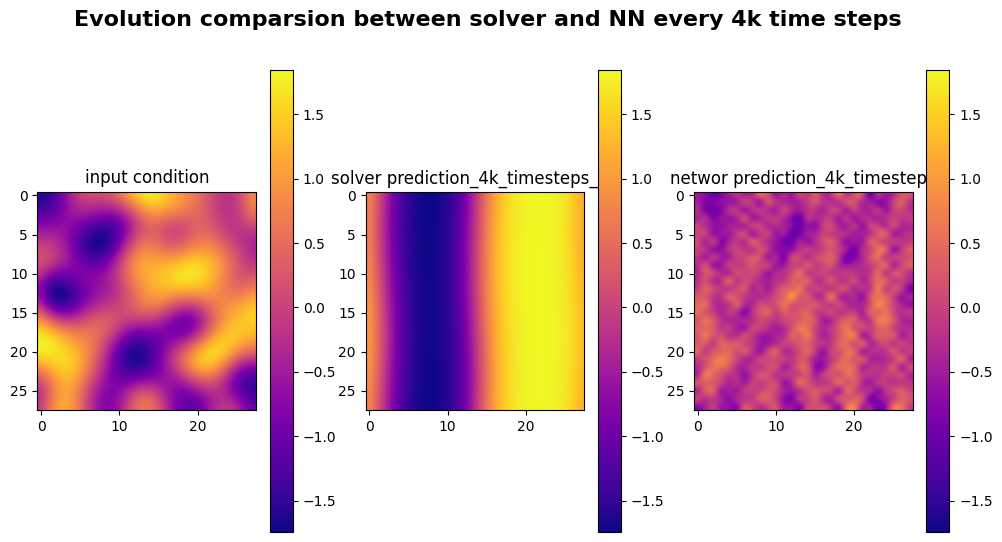

In [11]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import os






def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        
        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
        # print("Denominator shape:", denominator.shape)

        # Expand the denominator to match the shape of s_hat (28, 28, 1)
        denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
        print("Denominator shape after expansion:", denominator.shape)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        # print("Shape of s_hat (after fft2):", s_hat.shape)

        v_hat = s_hat / denominator  # Now shapes should match
        # print("Shape of v_hat (after division):", v_hat.shape)

        uk = jfft.ifft2(v_hat)  # inverse FFT
        # print("Shape of uk (after ifft2):", uk.shape)

        uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
        # print("Shape of uk after reshaping:", uk.shape)

        # Return the real part
        return jnp.real(uk)  # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, uk):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, uk) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
        u_ac = self.allen_cahn_equation(uk)
        datadriven_loss = jnp.mean((u_ac - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
       
        batch_loss = vmap(self.loss_single, (None, 0))(params, batch)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, uk):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, uk)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, dataset, data_test, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)  # Progress bar for total iterations


        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_batches(params, batch)
                loss_test = self.loss_batches(params, data_test)
                self.train_losses.append(loss)
                self.test_losses.append(loss_test)
                pbar.set_postfix({'train Loss': loss, 'test loss': loss_test})


    def pred(self, data_test):
        uk_solver_list = []
        uk_nnetwork_list = []
        

        for item in data_test:

            uk = self.allen_cahn_equation(item)
            # cahn = eps**2
            # uk = jnp.real(item)
           

            # # Compute denominator in Fourier space
            # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # # Perform FFT calculations
            # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            # v_hat = s_hat / denominator  
            # uk_ac = jfft.ifft2(v_hat)  
            uk_ac = uk.reshape(self.N, self.N, 1)
            uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(uk_solver, (uk_solver.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_solver, uk_nnetwork


    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.5 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
T = 4
Nt = int(jnp.round(T/dt))
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
# print(f'pp2 shape:{pp2.shape}')
# print(f'qq2 shape:{qq2.shape}')




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 5


def load_model(filename):
    # Load the saved model data
    with open(filename, 'rb') as f:
        save_dict = pickle.load(f)

    # Reconstruct the model based on the saved architecture type
    arch = save_dict['arch']
    N = save_dict['N']
    lr = save_dict['lr']
    eps = save_dict['eps']
    pp2 = save_dict['pp2']
    qq2 = save_dict['qq2']
    dt = save_dict['dt']
    L = save_dict['L']
    h = save_dict['h']
    x = save_dict['x']
    y = save_dict['y']

    # Reconstruct architecture layers (FNO, MLP, etc.)
    if arch == 'FNO':
        fno_layers = [
            Dense(64),
            Permute("ijkl->iljk"),
            FNOBlock2D(15),
            Gelu,
            FNOBlock2D(15),
            Gelu,
            FNOBlock2D(15),
            Permute("ijkl->iklj"),
            Dense(128),
            Gelu,
            Dense(1),
        ]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, [], lr, arch)

    elif arch == 'MLP':
        mlp_layers = [16384, 32, 32, 16384]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)

    elif arch == 'modified_MLP':
        mlp_layers = [16384, 32, 32, 16384]
        model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)
    else:
        raise ValueError(f"Unsupported architecture {arch}")

    # Restore model parameters and optimizer state
    model.params = save_dict['params']
    model.opt_state = save_dict['opt_state']
    model.train_losses = save_dict['train_losses']
    model.test_losses = save_dict['test_losses']
    
    return model


data = np.load('data_driven/data/driven_data_28x28_1k_input_samples.npy')
# # normalized_data, min_val, range_val = normalize(data) 
# # Generate the data trainig samples
# # dataset = DataGenerator(data[:9800], batch_size=20)
# data_test = data[9800:]
def allen_cahn_equation(uk):
    eps = 0.5
    cahn = eps**2
    uk = jnp.real(uk)

    # Compute denominator in Fourier space
    denominator = cahn + dt * (2 + cahn * (pp2 + qq2))

    # Perform FFT calculations
    s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 

    v_hat = s_hat / denominator  # Now shapes should match


    uk = jfft.ifft2(v_hat)  # inverse FFT

    # Return the real part
    return jnp.real(uk) 

# theta = jnp.arctan2(yy, xx)
#   # or another appropriate value
# uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * epsillon))
# uk_initial = uk
# uk_input = jnp.array(uk)
# uk_input = uk_input.reshape(N, N, 1)
# Directory to save images
output_dir = "data_driven/frames_4kstep"
os.makedirs(output_dir, exist_ok=True)
sample_idx = 13
title = f"Evolution comparsion (Allen Cahn and data_driven_model_4ktime steps_{sample_idx}"

def save_plot(data, model_data, iter_num):
    
    if model_data == '':
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(jnp.real(data), cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Initial Condition")
        fig.colorbar(im1, ax=axes)
        plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.close()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes[0].imshow(jnp.real(data), cmap='plasma', interpolation='bicubic')
        axes[0].set_title(f"Allen-Cahn Evolution at Iter {iter_num}")
        fig.colorbar(im1, ax=axes[0])
        
        im2 = axes[1].imshow(jnp.real(model_data), cmap='plasma', interpolation='bicubic')
        axes[1].set_title(f"Model Evolution at Iter {iter_num}")
        fig.colorbar(im2, ax=axes[1])
        
        plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.close()




#    # Initialize and train the model
# NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
loaded_model = load_model('data_driven/models/data_driven_pairstrategy_model_10000.pkl')
uk = data[sample_idx]
uk_ac = uk.reshape(N, N)
uk_initial = uk.reshape(N, N)
save_plot(uk, '', 0)
frames_4kstep = []
params =loaded_model.get_params(loaded_model.opt_state)

# Nt = 10000  # Define the number of iterations


for iter in range(1, Nt+1):
    
 
    uk_ac = allen_cahn_equation(uk_ac)
    if iter % 4000 == 0:
       
       
        uk_nnetwork = loaded_model.operator_net(params, uk)
        uk_nnetwork = uk_nnetwork.reshape(N, N)
        save_plot(uk_ac, uk_nnetwork, iter)
        frames_4kstep.append(f"{output_dir}/frame_{iter:04d}.png")
        uk =uk_nnetwork

        # r2, mse, l2_rel, u_solver, u_pred = loaded_model.pred(uk)
        # print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')

       
        # uk_ac = uk_reshape
        
uk_ac = uk_ac.reshape(N, N)
# NN_model.train(dataset, data_test, nIter = epochs)



fig, axes = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle(f"Evolution comparsion between solver and NN every 4k time steps", fontsize=16, fontweight='bold')
im1 = axes[0].imshow(jnp.real(uk_initial), cmap='plasma', interpolation='bicubic')
axes[0].set_title(f"input condition")
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(jnp.real(uk_ac), cmap='plasma', interpolation='bicubic')
axes[1].set_title(f"solver prediction_4k_timesteps_{sample_idx}")
fig.colorbar(im1, ax=axes[1])

im2 = axes[2].imshow(jnp.real(uk), cmap='plasma', interpolation='bicubic')
axes[2].set_title(f"networ prediction_4k_timesteps")
fig.colorbar(im1, ax=axes[2])
plt.savefig(f"data_driven/data_driven_plot/data_driven_evolution_comaprison_generatedsample_4k_{sample_idx}.png")
plt.show()


## animation plot

In [12]:
import matplotlib.pyplot as plt
import os
import imageio
from PIL import Image
import numpy as np


# Folder where images are saved
folder = "data_driven/frames_4kstep"

# Get the list of image files
image_files = sorted(
    [f for f in os.listdir(folder) if f.endswith(".png")],
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)

# Define a common size for all images (width, height)
common_size = (1200, 600)

# Read in the images and resize them using Resampling.BICUBIC
frames_resized = []
for filename in image_files:
    img = Image.open(os.path.join(folder, filename)).convert("RGB")  # Ensure RGB mode
    img = img.resize(common_size, Image.Resampling.BICUBIC)  # Try BICUBIC for smoother scaling
    frames_resized.append(np.array(img))

# Create a GIF with appropriate duration
output_dir = "data_driven/animation"
os.makedirs(output_dir, exist_ok=True)
gif_path = output_dir + f'/allen_cahn_vs_data_driven_model_evolution__4ktimesteps_10k_epoch_{sample_idx}.gif'
os.makedirs("animation", exist_ok=True)
imageio.mimsave(gif_path, frames_resized, duration=2000, format='GIF', palettesize=256)

print("GIF created with imageio at a smoother speed.")


GIF created with imageio at a smoother speed.


# checking allen cahn eqution is right or not 

pp2 data size :(28, 28)
uk ko size :(28, 28)


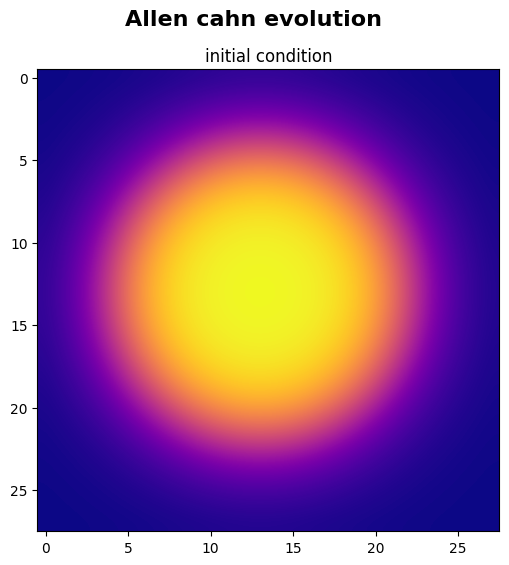

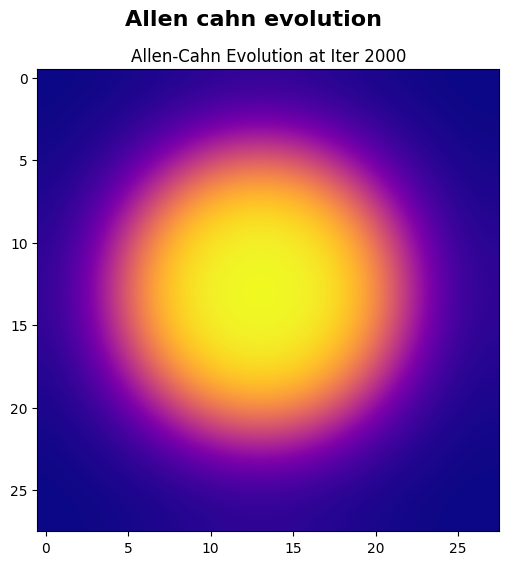

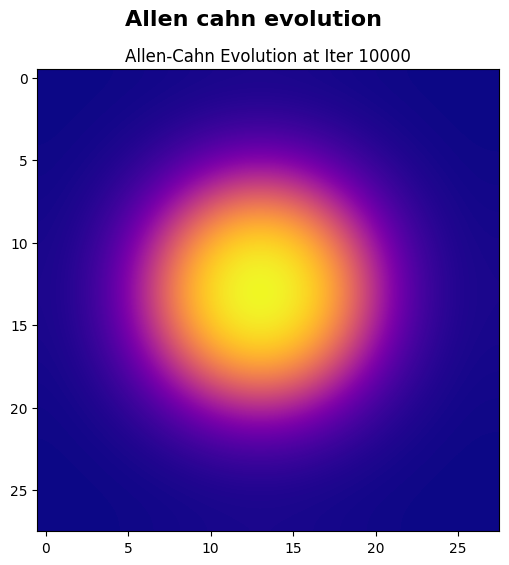

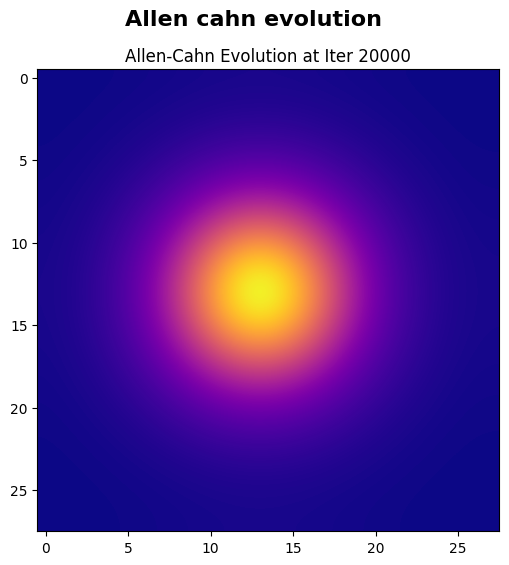

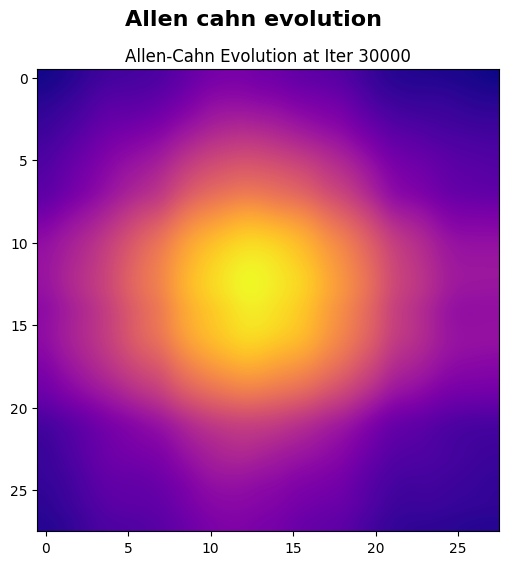

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import os
from numpy import sqrt


def allen_cahn_equation(uk):
    eps = 0.5
    cahn = eps**2
    uk = jnp.real(uk)

    # Compute denominator in Fourier space
    denominator = cahn + dt * (2 + cahn * (pp2 + qq2))

    # Perform FFT calculations
    s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 

    v_hat = s_hat / denominator  # Now shapes should match


    uk = jfft.ifft2(v_hat)  # inverse FFT

    # Return the real part
    return jnp.real(uk) 



# parameter

# Parameters
N = 28 # no. of grid points
eps = 0.5 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
T = 4
Nt = int(jnp.round(T/dt))
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
print(f'pp2 data size :{pp2.shape}')

# data = np.load('data_driven/data/driven_data_28x28_1k_input_samples.npy')
# print(f'data ko size :{data.shape}')

# data_reshape = data.reshape(-1, N, N)
# uk = data_reshape[0]

uk =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *eps))
print(f'uk ko size :{uk.shape}')

# sample_idx = 1
# figure1 = plt.figure()
# plt.contour(x, y, jnp.real(uk.T), [0], colors = 'black')
# plt.gca().set_aspect('equal', adjustable='box') 
# plt.title('Initial condition')
# plt.xlabel('x')
# plt.ylabel('y')
# # plt.show()
# if uk in sample_idx:
#     uk = allen_cahn_equation(uk)
title = 'Allen cahn evolution'

for iter in range(0, Nt):
    u = jnp.real(uk)
    uk = allen_cahn_equation(uk)

    if iter == 0:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"initial condition")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

    if iter == 2000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()
        
    if iter == 4000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.close()
    
    if iter == 10000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

    if iter == 20000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

    if iter == 30000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

# plt.show()



pp2 data size :(28, 28)


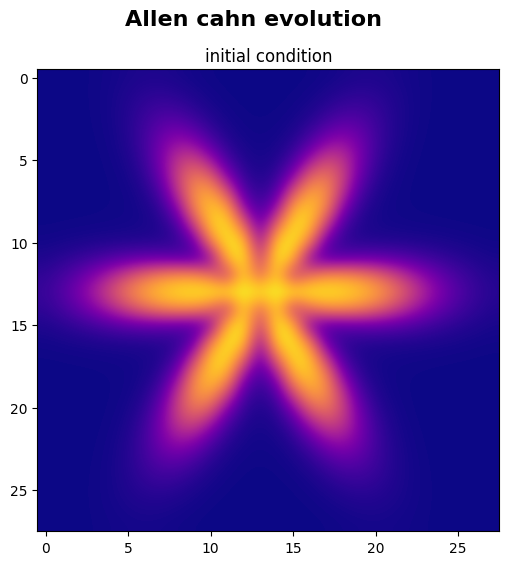

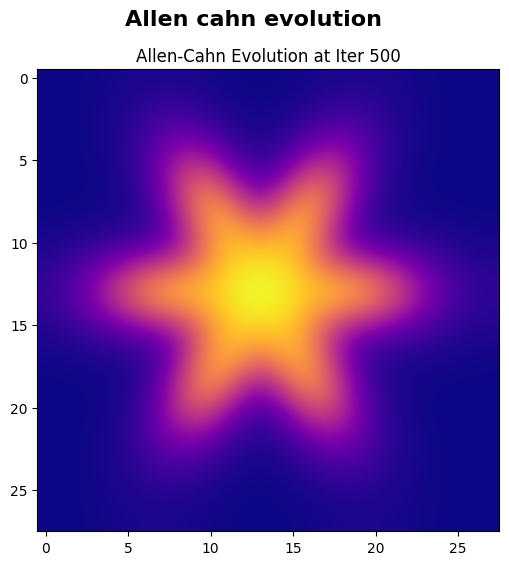

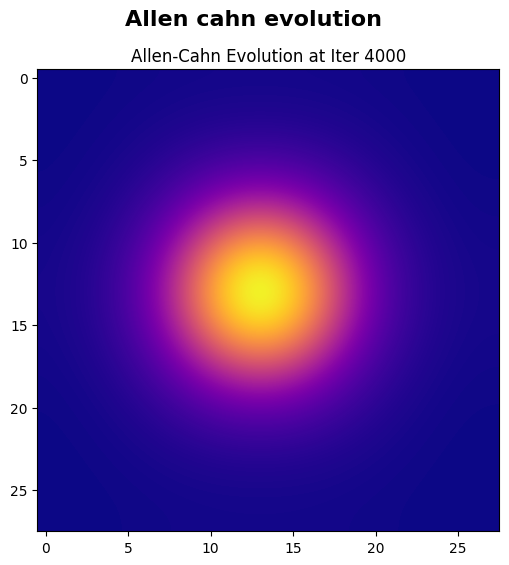

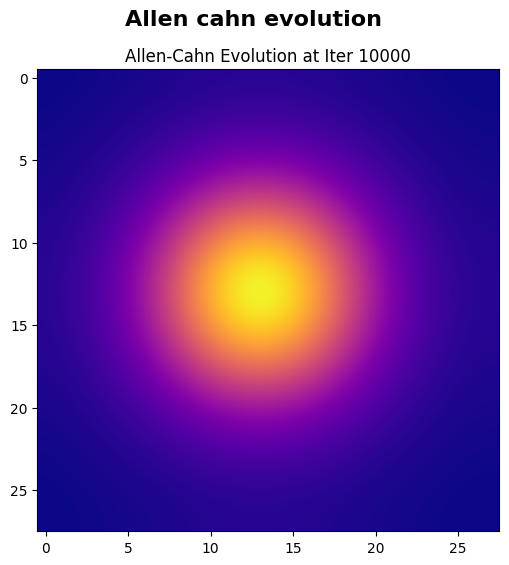

In [7]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import os
from numpy import sqrt


def allen_cahn_equation(uk):
    eps = 0.5
    cahn = eps**2
    uk = jnp.real(uk)

    # Compute denominator in Fourier space
    denominator = cahn + dt * (2 + cahn * (pp2 + qq2))

    # Perform FFT calculations
    s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 

    v_hat = s_hat / denominator  # Now shapes should match


    uk = jfft.ifft2(v_hat)  # inverse FFT

    # Return the real part
    return jnp.real(uk) 



# parameter

# Parameters
N = 28 # no. of grid points
eps = 0.5 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
T = 4
Nt = int(jnp.round(T/dt))
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
print(f'pp2 data size :{pp2.shape}')



theta = jnp.arctan2(yy, xx)
#   # or another appropriate value
uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * eps))

# sample_idx = 1
# figure1 = plt.figure()
# plt.contour(x, y, jnp.real(uk.T), [0], colors = 'black')
# plt.gca().set_aspect('equal', adjustable='box') 
# plt.title('Initial condition')
# plt.xlabel('x')
# plt.ylabel('y')
# # plt.show()
# if uk in sample_idx:
#     uk = allen_cahn_equation(uk)
title = 'Allen cahn evolution'

for iter in range(0, Nt):
    u = jnp.real(uk)
    uk = allen_cahn_equation(u)

    if iter == 0:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"initial condition")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

    if iter == 500:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()
        
    if iter == 2000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.close()
    
    if iter == 4000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

    if iter == 10000:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

    # if iter == 20000:
    #     fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    #     fig.suptitle(title, fontsize=16, fontweight='bold')

    #     im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
    #     axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
    #     # fig.colorbar(im1, ax=axes)
    #     # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
    #     plt.show()

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
import pickle
import os
from numpy import sqrt


def allen_cahn_equation(uk):
    eps = 0.5
    cahn = eps**2
    uk = jnp.real(uk)

    # Compute denominator in Fourier space
    denominator = cahn + dt * (2 + cahn * (pp2 + qq2))

    # Perform FFT calculations
    s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 

    v_hat = s_hat / denominator  # Now shapes should match


    uk = jfft.ifft2(v_hat)  # inverse FFT

    # Return the real part
    return jnp.real(uk) 



# parameter

# Parameters
N = 28 # no. of grid points
eps = 0.5 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
T = 4
Nt = int(jnp.round(T/dt))
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
print(f'pp2 data size :{pp2.shape}')



# theta = jnp.arctan2(yy, xx)
# #   # or another appropriate value
# uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * eps))
uk = np.load('data_driven/data/driven_data_28x28_1k_input_samples.npy')
uk = uk[0]
uk = uk.reshape(N, N)
sample_idx = 1
# figure1 = plt.figure()
# plt.contour(x, y, jnp.real(uk.T), [0], colors = 'black')
# plt.gca().set_aspect('equal', adjustable='box') 
# plt.title('Initial condition')
# plt.xlabel('x')
# plt.ylabel('y')
# # plt.show()
# if uk in sample_idx:
#     uk = allen_cahn_equation(uk)
title = 'Allen cahn evolution_{sample_idx}'

for iter in range(0, Nt):
    u = jnp.real(uk)
    uk = allen_cahn_equation(u)

    if iter == 0:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"initial condition")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()

    if iter % 500 == 0:
        fig, axes = plt.subplots(1, 1, figsize=(12, 6))
        fig.suptitle(title, fontsize=16, fontweight='bold')

        im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
        axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
        # fig.colorbar(im1, ax=axes)
        # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
        plt.show()
        
    # if iter == 2000:
    #     fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    #     fig.suptitle(title, fontsize=16, fontweight='bold')

    #     im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
    #     axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
    #     # fig.colorbar(im1, ax=axes)
    #     # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
    #     plt.close()
    
    # if iter == 4000:
    #     fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    #     fig.suptitle(title, fontsize=16, fontweight='bold')

    #     im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
    #     axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
    #     # fig.colorbar(im1, ax=axes)
    #     # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
    #     plt.show()

    # if iter == 10000:
    #     fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    #     fig.suptitle(title, fontsize=16, fontweight='bold')

    #     im1 = axes.imshow(uk, cmap='plasma', interpolation='bicubic')
    #     axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
    #     # fig.colorbar(im1, ax=axes)
    #     # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
    #     plt.show()

    # if iter == 20000:
    #     fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    #     fig.suptitle(title, fontsize=16, fontweight='bold')

    #     im1 = axes.imshow(u, cmap='plasma', interpolation='bicubic')
    #     axes.set_title(f"Allen-Cahn Evolution at Iter {iter}")
    #     # fig.colorbar(im1, ax=axes)
    #     # plt.savefig(f"{output_dir}/frame_{iter_num:04d}.png")
    #     plt.show()

# given the same input as 4k time_step data on 2k time_step

In [1]:

import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

import os 
# @partial(jit, static_argnums=(0,))
def allen_cahn_equation(uk, pp2, qq2, dt, eps, Nt):

    cahn = eps**2
    samples_timesteps = []

    for iter in range(0, Nt+1):
        uk = jnp.real(uk)
        # print(f'uk ko size inside the loop:{uk.shape}')

        # Compute denominator in Fourier space
        denominator = cahn + dt * (2 + cahn * (pp2 + qq2))

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk)) 

        v_hat = s_hat / denominator  # Now shapes should match


        uk = jfft.ifft2(v_hat)  # inverse FFT
        uk = jnp.real(uk)
        if iter % 500 == 0:
            samples_timesteps.append(uk)
    # print(f'uk ko size:(uk.shape)')
        # Return the real part
    return jnp.array(samples_timesteps)  # Return only the real part
    





# difinning the no of grid points in x, y and z
Nx = 28 # number of grid points in x be positive even integer number
Ny = 28 # number of grid points in y be positive even integer number



# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 10 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

epsillon = 0.5 #small parameter # interface thickness in the Allen-Cahn equation 
cahn = epsillon**2 #cahn number  

# theta = jnp.arctan2(yy, xx)
#   # or another appropriate value
# uk = jnp.tanh((1.7 + 1.2 * np.cos(6 * theta)) - jnp.sqrt(xx**2 + yy**2) / (jnp.sqrt(2) * epsillon))
# data = np.load('data_generation_checking/phasefield2d_data_28x28_10k.npy')
# print(f'data ko size:{data.shape}')

# # Select 1,000 random samples
# key = jax.random.PRNGKey(0)  # Random seed for reproducibility
# idx = jax.random.choice(key, data.shape[0], shape=(50,), replace=False)  # Random 1k indices
# input_samples = data[idx]  # Shape: (1000, Nx, Ny)
# print(f'input_sample ko size :{input_samples.shape}')

data = np.load('data_driven/data/driven_data_28x28_1k_input_samples.npy')
print(f'data ko size :{data.shape}')

input_samples = data[:, :, :]
print(f'input_samples ko size:{input_samples.shape}')


# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)


# input_samples= input_samples.reshape(-1, Nx , Ny)
# print(f'input_sample ko size :{input_samples.shape}')

samples = []

for i,uk in enumerate(input_samples):

    if i % 100 == 0:
        print(f'processing sample {i}...')
   
    ac_input = allen_cahn_equation(uk, pp2, qq2, dt, epsillon, Nt)
# print(f'shape of ac_input:{ac_input.shape}')
    samples.append(ac_input)
samples = jnp.array(samples)
print(f'samples ko shape:{samples.shape}')
      

# Specify the directory where y want to save the data
save_dir = './data_driven/data'

    # Ensure the directory exists, create it if not
os.makedirs(save_dir, exist_ok=True)

#saving the data 
# Save the training and testing data
# print("Saving training data to u_train.npy...")
np.save(os.path.join(save_dir, "driven_data_28x28_1k_input_samples_81step_every500kiter.npy"), np.array(input_samples))
np.save(os.path.join(save_dir, "driven_data_28x28_1ksample_81step_every500kiter.npy"), np.array(samples))



data ko size :(1000, 28, 28)
input_samples ko size:(1000, 28, 28)
processing sample 0...
processing sample 100...
processing sample 200...
processing sample 300...
processing sample 400...
processing sample 500...
processing sample 600...
processing sample 700...
processing sample 800...
processing sample 900...
samples ko shape:(1000, 81, 28, 28)


In [2]:
# Specify the directory where y want to save the data
save_dir = './data_driven/data'

    # Ensure the directory exists, create it if not
os.makedirs(save_dir, exist_ok=True)
# loaded the generated data
loaded_input_samples = np.load(os.path.join(save_dir, "driven_data_28x28_1k_input_samples_81step_every500kiter.npy"))
# print(f'loaded_input_samples ko shape:{loaded_input_samples.shape}')

loaded_samples = np.load(os.path.join(save_dir, "driven_data_28x28_1ksample_81step_every500kiter.npy"))
print(f'loaded_samples ko shape:{loaded_samples.shape}')
samples.shape

loaded_samples ko shape:(1000, 81, 28, 28)


(1000, 81, 28, 28)

# plot the samples

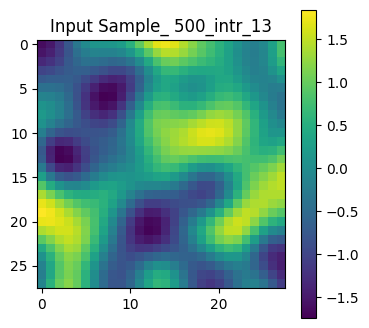

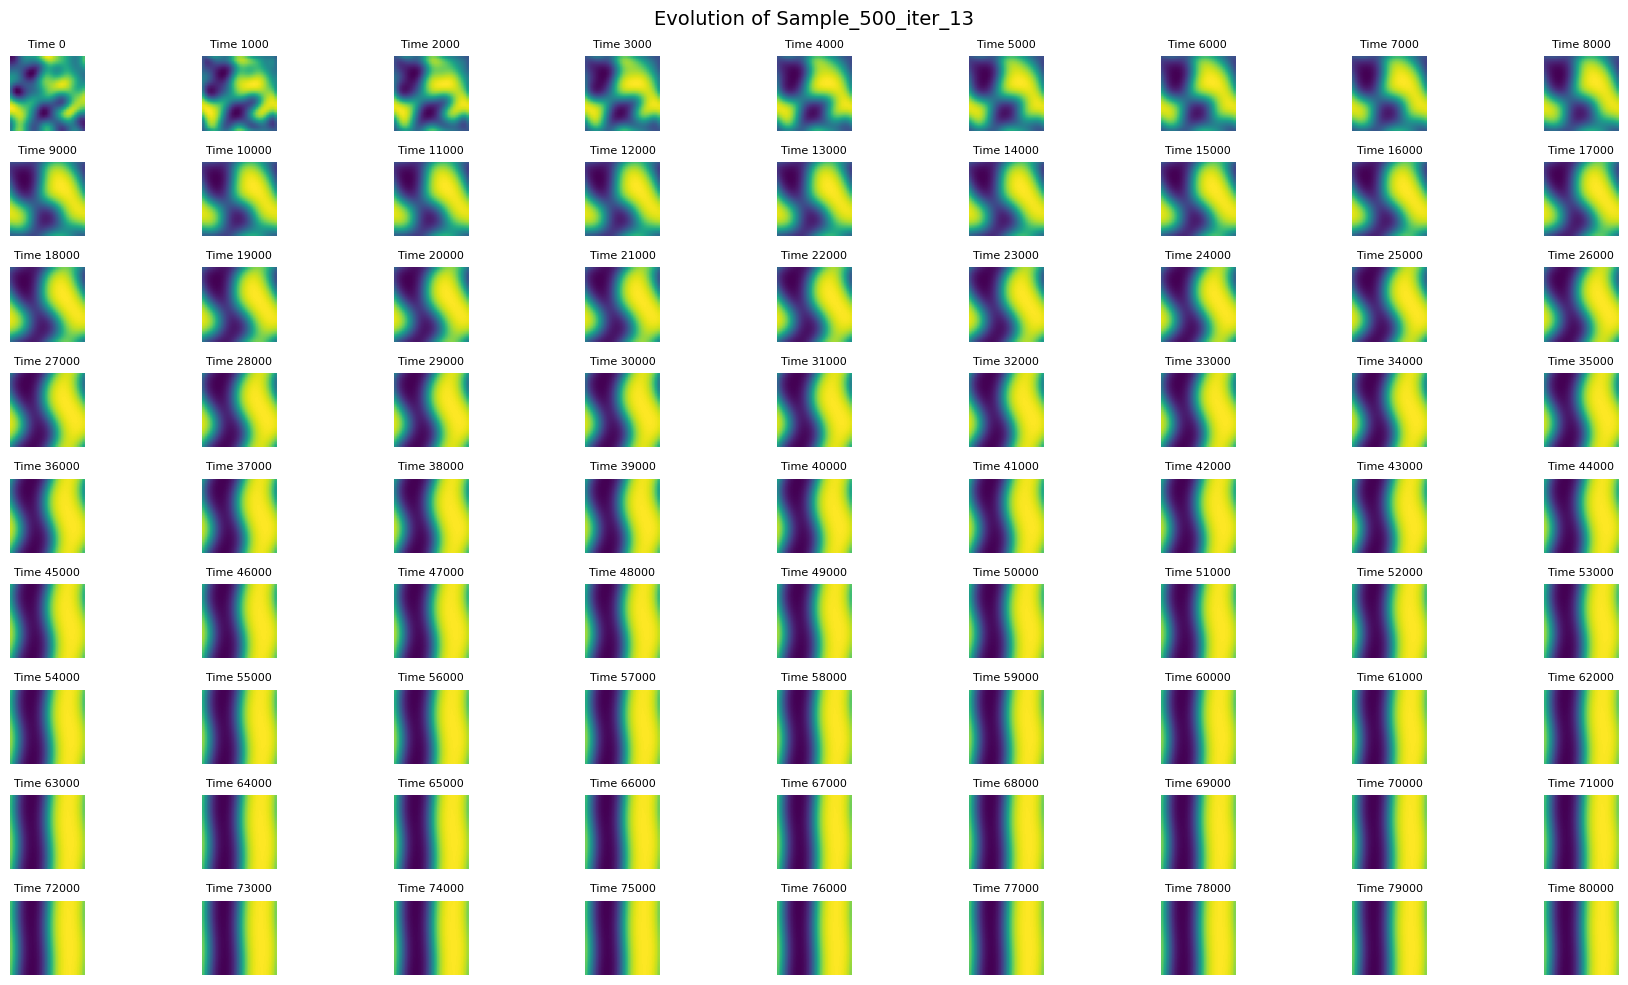

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

save_dir = './data_driven'

# Choose a sample index
sample_idx = 13

# Define the directory
plot_save_dir = os.path.join(save_dir,  "data_driven_plot")

# Create the directory if it doesn't exist
os.makedirs(plot_save_dir, exist_ok=True)


# Plot input data
plt.figure(figsize=(4, 4))
plt.imshow(loaded_input_samples[sample_idx], cmap='viridis')
plt.colorbar()
plt.title(f'Input Sample_ 500_intr_{sample_idx}')
plt.savefig(os.path.join(plot_save_dir, f'input_sample_1k_iter_{sample_idx}.png')) 
plt.show()


# Choose a sample index
sample_idx = 13

# fig, axes = plt.subplots(1, 41, figsize=(20, 4))  # 11 time steps

# for t in range(41):
#     axes[t].imshow(loaded_samples[sample_idx, t], cmap='viridis')
#     axes[t].set_title(f'Time {t * 1000}')
#     axes[t].axis('off')

# plt.suptitle(f'Evolution of Sample_1k_iter_{sample_idx}')
# # plt.savefig(os.path.join(plot_save_dir, f'Evolution_sample_1k_iter_{sample_idx}.png'))
# plt.show()

fig_rows = 9  # Number of rows
fig_cols = 9  # Number of columns (since 5x9 = 45, adjust if needed)

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(18, 10))

for t in range(81):
    row, col = divmod(t, fig_cols)  # Compute row and column indices
    axes[row, col].imshow(loaded_samples[sample_idx, t], cmap='viridis')
    axes[row, col].set_title(f'Time {t * 1000}', fontsize=8)
    axes[row, col].axis('off')

# Hide any unused subplots (if 45 slots but only 41 used)
for t in range(41, fig_rows * fig_cols):
    row, col = divmod(t, fig_cols)
    axes[row, col].axis('off')

plt.suptitle(f'Evolution of Sample_500_iter_{sample_idx}', fontsize=14)
# # plt.savefig(os.path.join(plot_save_dir, f'Evolution_sample_1k_iter_{sample_idx}.png'))
plt.tight_layout()
plt.show()



# import matplotlib.animation as animation

# fig, ax = plt.subplots()
# im = ax.imshow(loaded_samples[sample_idx, 0], cmap='viridis')

# def update(frame):
#     im.set_array(loaded_samples[sample_idx, frame])
#     ax.set_title(f'Time Step: {frame * 2000}')
#     return im,

# ani = animation.FuncAnimation(fig, update, frames=11, interval=500)

# # ani.save(evolution_animation.gif', writer='pillow')  # Save as GIF
# plt.show()


# training the model

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.example_libraries.optimizers import optimizer, make_schedule
# from jax.scipy.fftpack import fftn, ifftn
import numpy as np
import matplotlib.pyplot as plt
from torch import no_grad
from tqdm import trange
from functools import partial
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.example_libraries.optimizers import exponential_decay
import jax.numpy.fft as jfft
from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
from jax import vmap
from torch.utils import data
from jax import lax
from jax import debug
from jax.flatten_util import ravel_pytree
import itertools
from matplotlib.cm import tab20
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pickle




# # saving the parameter
def save_model(model, filename):
    # Save model parameters, architecture and optimizer state
    save_dict = {
        'arch': model.arch,
        'N': model.N,
        'lr': model.lr,
        'eps': model.eps,
        'pp2': model.pp2,
        'qq2': model.qq2,
        'dt': model.dt,
        'L': model.L,
        'h': model.h,
        'x': model.x,
        'y': model.y,
        'params': jax.device_get(model.get_params(model.opt_state)),
        'train_losses': model.train_losses,
        'test_losses': model.test_losses,
        'opt_state': jax.device_get(model.opt_state),  # Save optimizer state too
    }

    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)

def fft2(x):
   """Applies a 2D FFT over the first two dimensions of the input array x."""
   return fftn(x, axes=(0, 1))


def ifft2(x):
   """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
   return ifftn(x, axes=(0, 1))



# @jax.jit
def normalize(data):
    min_val = jnp.min(data, axis=(0, 1))
    max_val = jnp.max(data, axis=(0, 1))
    range_val = max_val - min_val
    range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
    normalized_data = 2 * (data - min_val) / range_val - 1
    return normalized_data, min_val, range_val 



def denormalize(normalized_data, min_val, range_val):
    range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
    data = ((normalized_data + 1) * range_val) / 2 + min_val
    return data



# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __len__(self):
        return self.N//self.batch_size
       
        
        

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u





class SPiFOL:
    def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
        self.arch = arch
        self.N = N
        self.lr = lr
        # self.norm_par = norm_par
        self.eps = eps
        self.pp2 = pp2
        self.qq2 = qq2
        self.dt = dt
        self.L = L
        self.h = h
        self.x = x
        self.y = y
        
        # Initialize the network based on architecture type
        if arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
            
        elif arch == 'MLP':
            self.N_init, self.N_apply = MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
            
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(mlp_layers)
            params = self.N_init(random.PRNGKey(1234))
        else:
            raise ValueError("Unsupported architecture!")


        self.params = params



        # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9)
            )

        self.opt_state = self.opt_init(self.params)
        


        # Logging losses
        self.train_losses = []
        self.test_losses = []  # Initialize list to track test losses


          # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()

       
  

    

    
    # @partial(jit, static_argnums=(0,))
    def operator_net(self, params, uk):
        if self.arch == 'FNO':
            
            input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
    
            O = self.N_apply(params, input_FNO)  # Apply the FNO network 
            O = O.reshape(self.N, self.N, 1)  # Reshape output
            return O
        elif self.arch == 'MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)  # Directly apply the network
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
            return O
        elif self.arch == 'modified_MLP':
            uk = uk.flatten()
            O = self.N_apply(params, uk)
            O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
            return O
        else:
            raise ValueError("Unsupported architecture type!")
      

    @partial(jit, static_argnums=(0,))
    def allen_cahn_equation(self, uk):
        
        cahn = eps**2
        uk = jnp.real(uk)

        # Compute denominator in Fourier space
        denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
        # print("Denominator shape:", denominator.shape)

        # Expand the denominator to match the shape of s_hat (28, 28, 1)
        denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
        # print("Denominator shape after expansion:", denominator.shape)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
        # print("Shape of s_hat (after fft2):", s_hat.shape)

        v_hat = s_hat / denominator  # Now shapes should match
        # print("Shape of v_hat (after division):", v_hat.shape)

        uk = jfft.ifft2(v_hat)  # inverse FFT
        # print("Shape of uk (after ifft2):", uk.shape)

        uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
        # print("Shape of uk after reshaping:", uk.shape)

        # Return the real part
        return jnp.real(uk)  # Return only the real part



    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, batch_input, batch_label):
        # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
        
        u_nn = self.operator_net(params, batch_input) # predicted or next value of the initial condition
        u_nn = u_nn.reshape(self.N, self.N, 1)     
       
        datadriven_loss = jnp.mean((batch_label - u_nn) ** 2)
        return datadriven_loss

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch_input, batch_label):
        # print(f'vmap agadi :{batch_input.shape, batch_label.shape}')
       
        batch_loss = vmap(self.loss_single, (None, 0, 0))(params, batch_input, batch_label)
        batch_loss  = jnp.mean(batch_loss)
        return batch_loss


    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch_input, batch_label):
        params = self.get_params(opt_state)
        grads = grad(self.loss_batches)(params, batch_input, batch_label)
        return self.opt_update(i, grads, opt_state)


   # Update the train method of tum_epochshe SPiFOL class
    def train(self, datatrain_input, datatrain_label,  datatest_input, datatest_label, nIter=10000):
        datainput_train_iter = iter(datatrain_input)
        datatrain_label_iter = iter(datatrain_label)
        pbar = trange(nIter)  # Progress bar for total iterations



        for it in pbar:
            batch_input_train = next(datainput_train_iter)
            batch_label_train= next(datatrain_label_iter)
            batch_input_train = jnp.array(batch_input_train)
            batch_label_train = jnp.array(batch_label_train)
            
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch_input_train, batch_label_train)

            if it % 5000 == 0:
                save_model(self, f'data_driven_pairstrategy_model_41ktimestep_every1k_iter_{it}.pkl')

            if it % 1 == 0:
                params = self.get_params(self.opt_state)
                loss_train = self.loss_batches(params, batch_input_train, batch_label_train)
                self.train_losses.append(loss_train)


                # for testing
                test_loss = []
                for _ in range(len(datatest_input)):
                    datatest_input_iter= iter(datatest_input)
                    datatest_label_iter= iter(datatest_label)
                    batch_input_test = next(datatest_input_iter)
                    batch_label_test= next(datatest_label_iter)
                    batch_input_test = jnp.array(batch_input_test)
                    batch_label_test = jnp.array(batch_label_test)


                    test_batch_loss = self.loss_batches(params, batch_input_test, batch_label_test)
                    test_loss.append(test_batch_loss)
                
                mean_test_loss = jnp.mean(jnp.array(test_loss))
                    
                self.test_losses.append(mean_test_loss)
            pbar.set_postfix({'train Loss': loss_train, 'test loss': mean_test_loss})


    def pred(self, data_test, data_label):
        # uk_solver_list = []
        uk_nnetwork_list = []
        

        for item in data_test:

            # uk = self.allen_cahn_equation(item)
            # cahn = eps**2
            # uk = jnp.real(item)
           

            # # Compute denominator in Fourier space
            # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
            
            # # Perform FFT calculations
            # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
            # v_hat = s_hat / denominator  
            # uk_ac = jfft.ifft2(v_hat)  
            # uk_ac = uk.reshape(self.N, self.N, 1)
            # uk_solver_list.append(uk_ac)

            params = self.get_params(self.opt_state)
    
            uk_nnetwork = self.operator_net(params, item)
            uk_nnetwork_list.append(uk_nnetwork)
        # uk_solver = jnp.array(uk_solver_list)
        uk_nnetwork = jnp.array(uk_nnetwork_list)

        #  flatten 
        u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
        u_true = jnp.reshape(data_label, (data_label.shape[0], -1))  
        
        # Compute R² Score
        r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

        # Compute Mean Squared Error (MSE)
        mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

        # Compute L₂ Relative Error (normalized error)
        l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

        
        
        return r2, mse, l2_rel, uk_nnetwork


    def plot_losses(self, save_as):
            # Convert loss array and jax numpy array for plotting
            total_train_loss = jnp.asarray(self.train_losses)
            total_test_loss = jnp.asarray(self.test_losses)
            
            
            #print(total_loss)
            color = tab20.colors
            x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

            #print(x_axis)
            # Create plot
            plt.figure(constrained_layout=True)
            ax = plt.subplot(111)

            plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
            plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
            #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
            #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
            plt.ylabel("Loss")
            plt.xlabel("Iterations")
            plt.title("data_driven_training_41timestep_every1kiter")
            plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
            plt.savefig(save_as + "Total_loss.png")

                


# Parameters
N = 28 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.001 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid
x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
xx, yy = jnp.meshgrid(x, y)


 # number of epochs for training


 # defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction
pp2, qq2 = jnp.meshgrid(p2, q2)
# print(f'pp2 shape:{pp2.shape}')
# print(f'qq2 shape:{qq2.shape}')




mlp_layers = [16384, 32, 32, 16384]


# Define FNO layers
fno_layers = [
   Dense(64),
   Permute("ijkl->iljk"),
   FNOBlock2D(15),
   Gelu,  # activation can be changed here
   FNOBlock2D(15),
   Gelu,
   FNOBlock2D(15),
   Permute("ijkl->iklj"),
   Dense(128),
   Gelu,
   Dense(1),
]

cahn = eps**2
epochs = 30000

data = np.load('data_driven/data/driven_data_28x28_1ksample_41timestep_every1kiter.npy') 
# pairing the dataset ex 0_timesteps -> 4k_timestep, 4k_timestep -> 8k_timesteps so on.
data_input = data[:, :-1, :, :] # in second array is the time, here extract all position of array expect last one 
data_label = data[:, 1:, :, :] # here aslo 2nd position array, extract all time position array excpect 1st position
# print(f'dataset ko shape:{data_input.shape, data_label.shape}')

# data_plot_input = data_input[610][0]# data_plot_label = data_label[610][9]
# fig, axes = plt.subplots(1, 2, figsize=(20, 4))  # 11 time steps
# print(axes)
# axes[0].imshow(data_plot_input)
# axes[1].imshow(data_plot_label)
# plt.show()


# Generate the data trainig samples
data_input_reshape = data_input.reshape(-1, N, N, 1)
data_label_reshape = data_label.reshape(-1, N, N, 1) # label is the gt here 
# print(f'dataset ko shape after reshape:{data_input_reshape.shape, data_label_reshape.shape}')

# sample_idx = 610
# original_sample = sample_idx//10
# time_step = sample_idx % 10

# assert np.array_equal(data_input_reshape[sample_idx], data_input[original_sample, time_step , :, :]), "Mismatch in data_train"
# assert np.array_equal(data_label_reshape[sample_idx], data_label[original_sample, time_step , :, :]), "Mismatch in data_gt"
# print("Correspondence verified successfully!")
# data_plot_input = data_input[original_sample, time_step , :, :]
# data_plot_input1 = data_input_reshape[sample_idx]
# data_plot_label = data_label[original_sample, time_step , :, :]
# data_plot_label1 = data_label_reshape[sample_idx]

# fig, axes = plt.subplots(1, 4, figsize=(8, 4))  # 11 time steps
# print(axes)
# axes[0].imshow(data_plot_input)
# axes[1].imshow(data_plot_input1)
# axes[2].imshow(data_plot_label)
# axes[3].imshow(data_plot_label1)
# plt.show()

# Split the dataset
train_input, test_input, train_label, test_label = train_test_split(
    data_input_reshape, data_label_reshape, test_size=0.1, random_state=42
)


# Print shapes to verify
# print(f"Train Input Shape: {train_input.shape}")
# print(f"Test Input Shape: {test_input.shape}")
# print(f"Train Prediction Shape: {train_label.shape}")
# print(f"Test Prediction Shape: {test_label.shape}")

train_input_batch = DataGenerator(train_input, batch_size=20)
train_label_batch = DataGenerator(train_label, batch_size=20)

test_input_batch = DataGenerator(test_input, batch_size=450)
test_label_batch = DataGenerator(test_label, batch_size=450)

# Print shapes to verify
# print(f"Train Input Shape: {train_input_batch[0].shape}")
# print(f"Test Input Shape: {test_input_batch[0].shape}")
# print(f"Train Prediction Shape: {train_label_batch[0].shape}")
# print(f"Test Prediction Shape: {test_label_batch[0].shape}")





#  # Specify the directory where y want to save the data
# save_dir = './data_driven//'

#      # Ensure the directory exists, create it if not
# os.makedirs(save_dir, exist_ok=True)



#    # Initialize and train the model
NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
NN_model.train(train_input_batch, train_label_batch,  test_input_batch, test_label_batch, nIter = epochs)

# Now call loss function
# loss = NN_model.loss_batches(params, batch_input, batch_label)
# r2, mse, l2_rel, u_pred = NN_model.pred(test_input, test_label)
# print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')

NN_model.plot_losses(f'data_driven/data_driven_plot/data_driven_every1ktimestep_training_log_iter_{epochs}.png')


save_model(NN_model, f'data_driven/models/data_driven_pairstrategy_model_41timestep_every1k_{epochs}.pkl')

## this is trianing complete code for collab

In [ ]:
    import jax
    import jax.numpy as jnp
    from jax import grad, jit, random
    from jax.example_libraries.stax import Dense, Gelu, serial
    from jax.example_libraries.optimizers import optimizer, make_schedule
    # from jax.scipy.fftpack import fftn, ifftn
    import numpy as np
    import matplotlib.pyplot as plt
    from torch import no_grad
    from tqdm import trange
    from functools import partial
    from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
    from jax.example_libraries.optimizers import exponential_decay
    import jax.numpy.fft as jfft
    from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
    from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
    from jax import vmap
    from torch.utils import data
    from jax import lax
    from jax import debug
    from jax.flatten_util import ravel_pytree
    import itertools
    from matplotlib.cm import tab20
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.model_selection import train_test_split
    import pickle




    # # saving the parameter
    def save_model(model, filename):
        # Save model parameters, architecture and optimizer state
        save_dict = {
            'arch': model.arch,
            'N': model.N,
            'lr': model.lr,
            'eps': model.eps,
            'pp2': model.pp2,
            'qq2': model.qq2,
            'dt': model.dt,
            'L': model.L,
            'h': model.h,
            'x': model.x,
            'y': model.y,
            'params': jax.device_get(model.get_params(model.opt_state)),
            'train_losses': model.train_losses,
            'test_losses': model.test_losses,
            'opt_state': jax.device_get(model.opt_state),  # Save optimizer state too
        }

        with open(filename, 'wb') as f:
            pickle.dump(save_dict, f)

    def fft2(x):
        """Applies a 2D FFT over the first two dimensions of the input array x."""
        return fftn(x, axes=(0, 1))


    def ifft2(x):
        """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
        return ifftn(x, axes=(0, 1))



    # @jax.jit
    def normalize(data):
        min_val = jnp.min(data, axis=(0, 1))
        max_val = jnp.max(data, axis=(0, 1))
        range_val = max_val - min_val
        range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
        normalized_data = 2 * (data - min_val) / range_val - 1
        return normalized_data, min_val, range_val 



    def denormalize(normalized_data, min_val, range_val):
        range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
        data = ((normalized_data + 1) * range_val) / 2 + min_val
        return data



    # Data genrator to make randomized batches
    class DataGenerator(data.Dataset):
        def __init__(self, u,
                    batch_size=64, rng_key=random.PRNGKey(1234)):
            'Initialization'
            self.u = u # input sample

            self.N = u.shape[0]
            self.batch_size = batch_size
            self.key = rng_key

        def __len__(self):
            return self.N//self.batch_size
        
            
            

        def __getitem__(self, index):
            'Generate one batch of data'
            self.key, subkey = random.split(self.key)
            u = self.__data_generation(subkey)
            return u

        #@partial(jit, static_argnums=(0,))
        def __data_generation(self, key):
            'Generates data containing batch_size samples'
            idx = random.choice(key, self.N, (self.batch_size,), replace=False)
            u = self.u[idx,:]
            # Construct batch
            return u





    class SPiFOL:
        def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
            self.arch = arch
            self.N = N
            self.lr = lr
            # self.norm_par = norm_par
            self.eps = eps
            self.pp2 = pp2
            self.qq2 = qq2
            self.dt = dt
            self.L = L
            self.h = h
            self.x = x
            self.y = y
            
            # Initialize the network based on architecture type
            if arch == 'FNO':
                self.N_init, self.N_apply = serial(*fno_layers)
                _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
                
            elif arch == 'MLP':
                self.N_init, self.N_apply = MLP(mlp_layers)
                params = self.N_init(random.PRNGKey(1234))
                
            elif arch == 'modified_MLP':
                self.N_init, self.N_apply = modified_MLP(mlp_layers)
                params = self.N_init(random.PRNGKey(1234))
            else:
                raise ValueError("Unsupported architecture!")


            self.params = params



            # Optimizer setup
            self.opt_init, self.opt_update, self.get_params = complex_adam(
                jax.example_libraries.optimizers.exponential_decay(
                    lr, decay_steps=2000, decay_rate=0.9)
                )

            self.opt_state = self.opt_init(self.params)
            


            # Logging losses
            self.train_losses = []
            self.test_losses = []  # Initialize list to track test losses


            # Initialize optimizer state
            self.opt_state = self.opt_init(self.params)
            _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
            self.itercount = itertools.count()

        
    

        

        
        # @partial(jit, static_argnums=(0,))
        def operator_net(self, params, uk):
            if self.arch == 'FNO':
                
                input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
        
                O = self.N_apply(params, input_FNO)  # Apply the FNO network 
                O = O.reshape(self.N, self.N, 1)  # Reshape output
                return O
            elif self.arch == 'MLP':
                uk = uk.flatten()
                O = self.N_apply(params, uk)  # Directly apply the network
                O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
                return O
            elif self.arch == 'modified_MLP':
                uk = uk.flatten()
                O = self.N_apply(params, uk)
                O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
                return O
            else:
                raise ValueError("Unsupported architecture type!")
        

        @partial(jit, static_argnums=(0,))
        def allen_cahn_equation(self, uk):
            
            cahn = eps**2
            uk = jnp.real(uk)

            # Compute denominator in Fourier space
            denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
            # print("Denominator shape:", denominator.shape)

            # Expand the denominator to match the shape of s_hat (28, 28, 1)
            denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
            # print("Denominator shape after expansion:", denominator.shape)

            # Perform FFT calculations
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
            # print("Shape of s_hat (after fft2):", s_hat.shape)

            v_hat = s_hat / denominator  # Now shapes should match
            # print("Shape of v_hat (after division):", v_hat.shape)

            uk = jfft.ifft2(v_hat)  # inverse FFT
            # print("Shape of uk (after ifft2):", uk.shape)

            uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
            # print("Shape of uk after reshaping:", uk.shape)

            # Return the real part
            return jnp.real(uk)  # Return only the real part



        @partial(jit, static_argnums=(0,))
        def loss_single(self, params, batch_input, batch_label):
            # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
            
            u_nn = self.operator_net(params, batch_input) # predicted or next value of the initial condition
            u_nn = u_nn.reshape(self.N, self.N, 1)     
        
            datadriven_loss = jnp.mean((batch_label - u_nn) ** 2)
            return datadriven_loss

        @partial(jit, static_argnums=(0,))
        def loss_batches(self, params, batch_input, batch_label):
            # print(f'vmap agadi :{batch_input.shape, batch_label.shape}')
        
            batch_loss = vmap(self.loss_single, (None, 0, 0))(params, batch_input, batch_label)
            batch_loss  = jnp.mean(batch_loss)
            return batch_loss


        @partial(jit, static_argnums=(0,))
        def step(self, i, opt_state, batch_input, batch_label):
            params = self.get_params(opt_state)
            grads = grad(self.loss_batches)(params, batch_input, batch_label)
            return self.opt_update(i, grads, opt_state)


    # Update the train method of tum_epochshe SPiFOL class
        def train(self, datatrain_input, datatrain_label,  datatest_input, datatest_label, nIter=10000):
            datainput_train_iter = iter(datatrain_input)
            datatrain_label_iter = iter(datatrain_label)
            pbar = trange(nIter)  # Progress bar for total iterations



            for it in pbar:
                batch_input_train = next(datainput_train_iter)
                batch_label_train= next(datatrain_label_iter)
                batch_input_train = jnp.array(batch_input_train)
                batch_label_train = jnp.array(batch_label_train)
                
                self.opt_state = self.step(next(self.itercount), self.opt_state, batch_input_train, batch_label_train)

                if it % 5000 == 0:
                    save_model(self, f'data_driven_pairstrategy_model_41ktimestep_every1k_iter_{it}.pkl')

                if it % 1 == 0:
                    params = self.get_params(self.opt_state)
                    loss_train = self.loss_batches(params, batch_input_train, batch_label_train)
                    self.train_losses.append(loss_train)


                    # for testing
                    test_loss = []
                    for _ in range(len(datatest_input)):
                        datatest_input_iter= iter(datatest_input)
                        datatest_label_iter= iter(datatest_label)
                        batch_input_test = next(datatest_input_iter)
                        batch_label_test= next(datatest_label_iter)
                        batch_input_test = jnp.array(batch_input_test)
                        batch_label_test = jnp.array(batch_label_test)


                        test_batch_loss = self.loss_batches(params, batch_input_test, batch_label_test)
                        test_loss.append(test_batch_loss)
                    
                    mean_test_loss = jnp.mean(jnp.array(test_loss))
                        
                    self.test_losses.append(mean_test_loss)
                pbar.set_postfix({'train Loss': loss_train, 'test loss': mean_test_loss})


        def pred(self, data_test, data_label):
            # uk_solver_list = []
            uk_nnetwork_list = []
            

            for item in data_test:

                # uk = self.allen_cahn_equation(item)
                # cahn = eps**2
                # uk = jnp.real(item)
            

                # # Compute denominator in Fourier space
                # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
                
                # # Perform FFT calculations
                # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
                # v_hat = s_hat / denominator  
                # uk_ac = jfft.ifft2(v_hat)  
                # uk_ac = uk.reshape(self.N, self.N, 1)
                # uk_solver_list.append(uk_ac)

                params = self.get_params(self.opt_state)
        
                uk_nnetwork = self.operator_net(params, item)
                uk_nnetwork_list.append(uk_nnetwork)
            # uk_solver = jnp.array(uk_solver_list)
            uk_nnetwork = jnp.array(uk_nnetwork_list)

            #  flatten 
            u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
            u_true = jnp.reshape(data_label, (data_label.shape[0], -1))  
            
            # Compute R² Score
            r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

            # Compute Mean Squared Error (MSE)
            mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

            # Compute L₂ Relative Error (normalized error)
            l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

            
            
            return r2, mse, l2_rel, uk_nnetwork


        def plot_losses(self, save_as):
                # Convert loss array and jax numpy array for plotting
                total_train_loss = jnp.asarray(self.train_losses)
                total_test_loss = jnp.asarray(self.test_losses)
                
                
                #print(total_loss)
                color = tab20.colors
                x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

                #print(x_axis)
                # Create plot
                plt.figure(constrained_layout=True)
                ax = plt.subplot(111)

                plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
                plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
                #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
                #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
                plt.ylabel("Loss")
                plt.xlabel("Iterations")
                plt.title("data_driven_training_41timestep_every1kiter")
                plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
                plt.savefig(save_as + "Total_loss.png")

                    


    # Parameters
    N = 28 # no. of grid points
    eps = 0.05 # epsillon 
    lr = 0.001 # learning rate
    dt = 0.0001 # time step or time increment
    L = 2 * jnp.pi # length of domian
    h = L/N # spacing between grid or length of grid
    x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
    y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
    xx, yy = jnp.meshgrid(x, y)


    # number of epochs for training


    # defining the wavenumber in x and y direction , which is in fourier space
    p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
    q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
    p2 = p**2 # square of wavenumber in x direction
    q2 = q**2 # square of wavenumber in y direction
    pp2, qq2 = jnp.meshgrid(p2, q2)
    # print(f'pp2 shape:{pp2.shape}')
    # print(f'qq2 shape:{qq2.shape}')




    mlp_layers = [16384, 32, 32, 16384]


    # Define FNO layers
    fno_layers = [
    Dense(64),
    Permute("ijkl->iljk"),
    FNOBlock2D(15),
    Gelu,  # activation can be changed here
    FNOBlock2D(15),
    Gelu,
    FNOBlock2D(15),
    Permute("ijkl->iklj"),
    Dense(128),
    Gelu,
    Dense(1),
    ]

    cahn = eps**2
    epochs = 30000

    data = np.load('driven_data_28x28_1ksample_41timestep_every1kiter.npy') 
    # pairing the dataset ex 0_timesteps -> 4k_timestep, 4k_timestep -> 8k_timesteps so on.
    data_input = data[:, :-1, :, :] # in second array is the time, here extract all position of array expect last one 
    data_label = data[:, 1:, :, :] # here aslo 2nd position array, extract all time position array excpect 1st position
    # print(f'dataset ko shape:{data_input.shape, data_label.shape}')

    # data_plot_input = data_input[610][0]# data_plot_label = data_label[610][9]
    # fig, axes = plt.subplots(1, 2, figsize=(20, 4))  # 11 time steps
    # print(axes)
    # axes[0].imshow(data_plot_input)
    # axes[1].imshow(data_plot_label)
    # plt.show()


    # Generate the data trainig samples
    data_input_reshape = data_input.reshape(-1, N, N, 1)
    data_label_reshape = data_label.reshape(-1, N, N, 1) # label is the gt here 
    # print(f'dataset ko shape after reshape:{data_input_reshape.shape, data_label_reshape.shape}')

    # sample_idx = 610
    # original_sample = sample_idx//10
    # time_step = sample_idx % 10

    # assert np.array_equal(data_input_reshape[sample_idx], data_input[original_sample, time_step , :, :]), "Mismatch in data_train"
    # assert np.array_equal(data_label_reshape[sample_idx], data_label[original_sample, time_step , :, :]), "Mismatch in data_gt"
    # print("Correspondence verified successfully!")
    # data_plot_input = data_input[original_sample, time_step , :, :]
    # data_plot_input1 = data_input_reshape[sample_idx]
    # data_plot_label = data_label[original_sample, time_step , :, :]
    # data_plot_label1 = data_label_reshape[sample_idx]

    # fig, axes = plt.subplots(1, 4, figsize=(8, 4))  # 11 time steps
    # print(axes)
    # axes[0].imshow(data_plot_input)
    # axes[1].imshow(data_plot_input1)
    # axes[2].imshow(data_plot_label)
    # axes[3].imshow(data_plot_label1)
    # plt.show()

    # Split the dataset
    train_input, test_input, train_label, test_label = train_test_split(
        data_input_reshape, data_label_reshape, test_size=0.1, random_state=42
    )


    # Print shapes to verify
    # print(f"Train Input Shape: {train_input.shape}")
    # print(f"Test Input Shape: {test_input.shape}")
    # print(f"Train Prediction Shape: {train_label.shape}")
    # print(f"Test Prediction Shape: {test_label.shape}")

    train_input_batch = DataGenerator(train_input, batch_size=20)
    train_label_batch = DataGenerator(train_label, batch_size=20)

    test_input_batch = DataGenerator(test_input, batch_size=450)
    test_label_batch = DataGenerator(test_label, batch_size=450)

    # Print shapes to verify
    # print(f"Train Input Shape: {train_input_batch[0].shape}")
    # print(f"Test Input Shape: {test_input_batch[0].shape}")
    # print(f"Train Prediction Shape: {train_label_batch[0].shape}")
    # print(f"Test Prediction Shape: {test_label_batch[0].shape}")





    #  # Specify the directory where y want to save the data
    # save_dir = './data_driven//'

    #      # Ensure the directory exists, create it if not
    # os.makedirs(save_dir, exist_ok=True)



    #    # Initialize and train the model
    NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
    NN_model.train(train_input_batch, train_label_batch,  test_input_batch, test_label_batch, nIter = epochs)

    # Now call loss function
    # loss = NN_model.loss_batches(params, batch_input, batch_label)
    # r2, mse, l2_rel, u_pred = NN_model.pred(test_input, test_label)
    # print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')

    NN_model.plot_losses(f'data_driven_every1ktimestep_training_log_iter_{epochs}.png')


    save_model(NN_model, f'data_driven_pairstrategy_model_41timestep_every1k_{epochs}.pkl')

In [ ]:
    import jax
    import jax.numpy as jnp
    from jax import grad, jit, random
    from jax.example_libraries.stax import Dense, Gelu, serial
    from jax.example_libraries.optimizers import optimizer, make_schedule
    # from jax.scipy.fftpack import fftn, ifftn
    import numpy as np
    import matplotlib.pyplot as plt
    from torch import no_grad
    from tqdm import trange
    from functools import partial
    from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
    from jax.example_libraries.optimizers import exponential_decay
    import jax.numpy.fft as jfft
    from jax.example_libraries.stax import Dense, Gelu, serial, glorot_normal
    from spifol_archs import FNOBlock2D, Permute, complex_adam, MLP, modified_MLP
    from jax import vmap
    from torch.utils import data
    from jax import lax
    from jax import debug
    from jax.flatten_util import ravel_pytree
    import itertools
    from matplotlib.cm import tab20
    from sklearn.metrics import r2_score, mean_squared_error
    from sklearn.model_selection import train_test_split
    import pickle


    def load_model(filename):
      # Load the saved model data
      with open(filename, 'rb') as f:
          save_dict = pickle.load(f)

      # Reconstruct the model based on the saved architecture type
      arch = save_dict['arch']
      N = save_dict['N']
      lr = save_dict['lr']
      eps = save_dict['eps']
      pp2 = save_dict['pp2']
      qq2 = save_dict['qq2']
      dt = save_dict['dt']
      L = save_dict['L']
      h = save_dict['h']
      x = save_dict['x']
      y = save_dict['y']

      # Reconstruct architecture layers (FNO, MLP, etc.)
      if arch == 'FNO':
          fno_layers = [
              Dense(64),
              Permute("ijkl->iljk"),
              FNOBlock2D(15),
              Gelu,
              FNOBlock2D(15),
              Gelu,
              FNOBlock2D(15),
              Permute("ijkl->iklj"),
              Dense(128),
              Gelu,
              Dense(1),
          ]
          model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, [], lr, arch)

      elif arch == 'MLP':
          mlp_layers = [16384, 32, 32, 16384]
          model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)

      elif arch == 'modified_MLP':
          mlp_layers = [16384, 32, 32, 16384]
          model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, [], mlp_layers, lr, arch)
      else:
          raise ValueError(f"Unsupported architecture {arch}")

      # Restore model parameters and optimizer state
      model.params = save_dict['params']
      model.opt_state = save_dict['opt_state']
      model.train_losses = save_dict['train_losses']
      model.test_losses = save_dict['test_losses']
      
      return model





    # # saving the parameter
    def save_model(model, filename):
        # Save model parameters, architecture and optimizer state
        save_dict = {
            'arch': model.arch,
            'N': model.N,
            'lr': model.lr,
            'eps': model.eps,
            'pp2': model.pp2,
            'qq2': model.qq2,
            'dt': model.dt,
            'L': model.L,
            'h': model.h,
            'x': model.x,
            'y': model.y,
            'params': jax.device_get(model.get_params(model.opt_state)),
            'train_losses': model.train_losses,
            'test_losses': model.test_losses,
            'opt_state': jax.device_get(model.opt_state),  # Save optimizer state too
        }

        with open(filename, 'wb') as f:
            pickle.dump(save_dict, f)

    def fft2(x):
        """Applies a 2D FFT over the first two dimensions of the input array x."""
        return fftn(x, axes=(0, 1))


    def ifft2(x):
        """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
        return ifftn(x, axes=(0, 1))



    # @jax.jit
    def normalize(data):
        min_val = jnp.min(data, axis=(0, 1))
        max_val = jnp.max(data, axis=(0, 1))
        range_val = max_val - min_val
        range_val = jnp.where(range_val == 0, 1, range_val)  # Avoid division by zero
        normalized_data = 2 * (data - min_val) / range_val - 1
        return normalized_data, min_val, range_val 



    def denormalize(normalized_data, min_val, range_val):
        range_val = jnp.where(range_val == 0, 1, range_val)  # Ensure no division by zero
        data = ((normalized_data + 1) * range_val) / 2 + min_val
        return data



    # Data genrator to make randomized batches
    class DataGenerator(data.Dataset):
        def __init__(self, u,
                    batch_size=64, rng_key=random.PRNGKey(1234)):
            'Initialization'
            self.u = u # input sample

            self.N = u.shape[0]
            self.batch_size = batch_size
            self.key = rng_key

        def __len__(self):
            return self.N//self.batch_size
        
            
            

        def __getitem__(self, index):
            'Generate one batch of data'
            self.key, subkey = random.split(self.key)
            u = self.__data_generation(subkey)
            return u

        #@partial(jit, static_argnums=(0,))
        def __data_generation(self, key):
            'Generates data containing batch_size samples'
            idx = random.choice(key, self.N, (self.batch_size,), replace=False)
            u = self.u[idx,:]
            # Construct batch
            return u





    class SPiFOL:
        def __init__(self, L, x, y, h, eps, pp2, qq2, dt,  N, fno_layers, mlp_layers,lr, arch):
            self.arch = arch
            self.N = N
            self.lr = lr
            # self.norm_par = norm_par
            self.eps = eps
            self.pp2 = pp2
            self.qq2 = qq2
            self.dt = dt
            self.L = L
            self.h = h
            self.x = x
            self.y = y
            
            # Initialize the network based on architecture type
            if arch == 'FNO':
                self.N_init, self.N_apply = serial(*fno_layers)
                _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 1))
                
            elif arch == 'MLP':
                self.N_init, self.N_apply = MLP(mlp_layers)
                params = self.N_init(random.PRNGKey(1234))
                
            elif arch == 'modified_MLP':
                self.N_init, self.N_apply = modified_MLP(mlp_layers)
                params = self.N_init(random.PRNGKey(1234))
            else:
                raise ValueError("Unsupported architecture!")


            self.params = params



            # Optimizer setup
            self.opt_init, self.opt_update, self.get_params = complex_adam(
                jax.example_libraries.optimizers.exponential_decay(
                    lr, decay_steps=2000, decay_rate=0.9)
                )

            self.opt_state = self.opt_init(self.params)
            


            # Logging losses
            self.train_losses = []
            self.test_losses = []  # Initialize list to track test losses


            # Initialize optimizer state
            self.opt_state = self.opt_init(self.params)
            _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
            self.itercount = itertools.count()

        
    

        

        
        # @partial(jit, static_argnums=(0,))
        def operator_net(self, params, uk):
            if self.arch == 'FNO':
                
                input_FNO = uk.reshape(-1, self.N, self.N, 1)  # Reshape for FNO
        
                O = self.N_apply(params, input_FNO)  # Apply the FNO network 
                O = O.reshape(self.N, self.N, 1)  # Reshape output
                return O
            elif self.arch == 'MLP':
                uk = uk.flatten()
                O = self.N_apply(params, uk)  # Directly apply the network
                O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])  # Reshape output to match strain components
                return O
            elif self.arch == 'modified_MLP':
                uk = uk.flatten()
                O = self.N_apply(params, uk)
                O = O.reshape(uk.shape[0], self.N, self.N, uk.shape[3])
                return O
            else:
                raise ValueError("Unsupported architecture type!")
        

        @partial(jit, static_argnums=(0,))
        def allen_cahn_equation(self, uk):
            
            cahn = eps**2
            uk = jnp.real(uk)

            # Compute denominator in Fourier space
            denominator = cahn + self.dt * (2 + cahn * (self.pp2 + self.qq2))
            # print("Denominator shape:", denominator.shape)

            # Expand the denominator to match the shape of s_hat (28, 28, 1)
            denominator = denominator[..., None]  # Add a third dimension to make the shape (28, 28, 1)
            # print("Denominator shape after expansion:", denominator.shape)

            # Perform FFT calculations
            s_hat = jfft.fft2(cahn * uk - self.dt * (uk**3 - 3 * uk)) 
            # print("Shape of s_hat (after fft2):", s_hat.shape)

            v_hat = s_hat / denominator  # Now shapes should match
            # print("Shape of v_hat (after division):", v_hat.shape)

            uk = jfft.ifft2(v_hat)  # inverse FFT
            # print("Shape of uk (after ifft2):", uk.shape)

            uk = uk.reshape(self.N, self.N, 1)  # Reshaping to (N, N, 1)
            # print("Shape of uk after reshaping:", uk.shape)

            # Return the real part
            return jnp.real(uk)  # Return only the real part



        @partial(jit, static_argnums=(0,))
        def loss_single(self, params, batch_input, batch_label):
            # uk is the input data and u_nn is the next uK+1 data of neural network and u_ac is also next u_ac_k+1 data
            
            u_nn = self.operator_net(params, batch_input) # predicted or next value of the initial condition
            u_nn = u_nn.reshape(self.N, self.N, 1)     
        
            datadriven_loss = jnp.mean((batch_label - u_nn) ** 2)
            return datadriven_loss

        @partial(jit, static_argnums=(0,))
        def loss_batches(self, params, batch_input, batch_label):
            # print(f'vmap agadi :{batch_input.shape, batch_label.shape}')
        
            batch_loss = vmap(self.loss_single, (None, 0, 0))(params, batch_input, batch_label)
            batch_loss  = jnp.mean(batch_loss)
            return batch_loss


        @partial(jit, static_argnums=(0,))
        def step(self, i, opt_state, batch_input, batch_label):
            params = self.get_params(opt_state)
            grads = grad(self.loss_batches)(params, batch_input, batch_label)
            return self.opt_update(i, grads, opt_state)


    # Update the train method of tum_epochshe SPiFOL class
        def train(self, datatrain_input, datatrain_label,  datatest_input, datatest_label, nIter=10000):
            datainput_train_iter = iter(datatrain_input)
            datatrain_label_iter = iter(datatrain_label)
            pbar = trange(nIter)  # Progress bar for total iterations



            for it in pbar:
                batch_input_train = next(datainput_train_iter)
                batch_label_train= next(datatrain_label_iter)
                batch_input_train = jnp.array(batch_input_train)
                batch_label_train = jnp.array(batch_label_train)
                
                self.opt_state = self.step(next(self.itercount), self.opt_state, batch_input_train, batch_label_train)

                if it % 5000 == 0:
                    save_model(self, f'data_driven_pairstrategy_model_41ktimestep_every1k_iter_{15000 + it}.pkl')
                    self.plot_losses(f'data_driven_every1ktimestep_training_log_iter_{15000 + it}.png')

                if it % 1 == 0:
                    params = self.get_params(self.opt_state)
                    loss_train = self.loss_batches(params, batch_input_train, batch_label_train)
                    self.train_losses.append(loss_train)


                    # for testing
                    test_loss = []
                    for _ in range(len(datatest_input)):
                        datatest_input_iter= iter(datatest_input)
                        datatest_label_iter= iter(datatest_label)
                        batch_input_test = next(datatest_input_iter)
                        batch_label_test= next(datatest_label_iter)
                        batch_input_test = jnp.array(batch_input_test)
                        batch_label_test = jnp.array(batch_label_test)


                        test_batch_loss = self.loss_batches(params, batch_input_test, batch_label_test)
                        test_loss.append(test_batch_loss)
                    
                    mean_test_loss = jnp.mean(jnp.array(test_loss))
                        
                    self.test_losses.append(mean_test_loss)
                pbar.set_postfix({'train Loss': loss_train, 'test loss': mean_test_loss})


        def pred(self, data_test, data_label):
            # uk_solver_list = []
            uk_nnetwork_list = []
            

            for item in data_test:

                # uk = self.allen_cahn_equation(item)
                # cahn = eps**2
                # uk = jnp.real(item)
            

                # # Compute denominator in Fourier space
                # denominator = cahn + dt * (2 + cahn * (pp2 + qq2)) 
                
                # # Perform FFT calculations
                # s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  
                # v_hat = s_hat / denominator  
                # uk_ac = jfft.ifft2(v_hat)  
                # uk_ac = uk.reshape(self.N, self.N, 1)
                # uk_solver_list.append(uk_ac)

                params = self.get_params(self.opt_state)
        
                uk_nnetwork = self.operator_net(params, item)
                uk_nnetwork_list.append(uk_nnetwork)
            # uk_solver = jnp.array(uk_solver_list)
            uk_nnetwork = jnp.array(uk_nnetwork_list)

            #  flatten 
            u_pred = jnp.reshape(uk_nnetwork, (uk_nnetwork.shape[0], -1 ))  
            u_true = jnp.reshape(data_label, (data_label.shape[0], -1))  
            
            # Compute R² Score
            r2 = r2_score(jnp.array(u_true), jnp.array(u_pred))  

            # Compute Mean Squared Error (MSE)
            mse = mean_squared_error(jnp.array(u_true), jnp.array(u_pred))  

            # Compute L₂ Relative Error (normalized error)
            l2_rel = jnp.linalg.norm(u_true - u_pred) / jnp.linalg.norm(u_true)  # L2 error

            
            
            return r2, mse, l2_rel, uk_nnetwork


        def plot_losses(self, save_as):
                # Convert loss array and jax numpy array for plotting
                total_train_loss = jnp.asarray(self.train_losses)
                total_test_loss = jnp.asarray(self.test_losses)
                
                
                #print(total_loss)
                color = tab20.colors
                x_axis = jnp.arange(1, total_train_loss.size + 1, 1) # x_axis: Epoch numbers from 1 to 100

                #print(x_axis)
                # Create plot
                plt.figure(constrained_layout=True)
                ax = plt.subplot(111)

                plt.semilogy(x_axis, total_train_loss, label="Train", c=color[0])
                plt.semilogy(x_axis, total_test_loss, label="Test", c=color[6])
                #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
                #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
                plt.ylabel("Loss")
                plt.xlabel("Iterations")
                plt.title("data_driven_training_41timestep_every1kiter")
                plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
                plt.savefig(save_as + "Total_loss.png")

                    


    # Parameters
    N = 28 # no. of grid points
    eps = 0.05 # epsillon 
    lr = 0.001 # learning rate
    dt = 0.0001 # time step or time increment
    L = 2 * jnp.pi # length of domian
    h = L/N # spacing between grid or length of grid
    x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
    y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
    xx, yy = jnp.meshgrid(x, y)


    # number of epochs for training


    # defining the wavenumber in x and y direction , which is in fourier space
    p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)]) # wavenumber in x direction
    q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2 , 0)])
    p2 = p**2 # square of wavenumber in x direction
    q2 = q**2 # square of wavenumber in y direction
    pp2, qq2 = jnp.meshgrid(p2, q2)
    # print(f'pp2 shape:{pp2.shape}')
    # print(f'qq2 shape:{qq2.shape}')




    mlp_layers = [16384, 32, 32, 16384]


    # Define FNO layers
    fno_layers = [
    Dense(64),
    Permute("ijkl->iljk"),
    FNOBlock2D(15),
    Gelu,  # activation can be changed here
    FNOBlock2D(15),
    Gelu,
    FNOBlock2D(15),
    Permute("ijkl->iklj"),
    Dense(128),
    Gelu,
    Dense(1),
    ]

    cahn = eps**2
    epochs = 30000

    data = np.load('driven_data_28x28_1ksample_41timestep_every1kiter.npy') 
    # pairing the dataset ex 0_timesteps -> 4k_timestep, 4k_timestep -> 8k_timesteps so on.
    data_input = data[:, :-1, :, :] # in second array is the time, here extract all position of array expect last one 
    data_label = data[:, 1:, :, :] # here aslo 2nd position array, extract all time position array excpect 1st position
    # print(f'dataset ko shape:{data_input.shape, data_label.shape}')

    # data_plot_input = data_input[610][0]# data_plot_label = data_label[610][9]
    # fig, axes = plt.subplots(1, 2, figsize=(20, 4))  # 11 time steps
    # print(axes)
    # axes[0].imshow(data_plot_input)
    # axes[1].imshow(data_plot_label)
    # plt.show()


    # Generate the data trainig samples
    data_input_reshape = data_input.reshape(-1, N, N, 1)
    data_label_reshape = data_label.reshape(-1, N, N, 1) # label is the gt here 
    # print(f'dataset ko shape after reshape:{data_input_reshape.shape, data_label_reshape.shape}')

    # sample_idx = 610
    # original_sample = sample_idx//10
    # time_step = sample_idx % 10

    # assert np.array_equal(data_input_reshape[sample_idx], data_input[original_sample, time_step , :, :]), "Mismatch in data_train"
    # assert np.array_equal(data_label_reshape[sample_idx], data_label[original_sample, time_step , :, :]), "Mismatch in data_gt"
    # print("Correspondence verified successfully!")
    # data_plot_input = data_input[original_sample, time_step , :, :]
    # data_plot_input1 = data_input_reshape[sample_idx]
    # data_plot_label = data_label[original_sample, time_step , :, :]
    # data_plot_label1 = data_label_reshape[sample_idx]

    # fig, axes = plt.subplots(1, 4, figsize=(8, 4))  # 11 time steps
    # print(axes)
    # axes[0].imshow(data_plot_input)
    # axes[1].imshow(data_plot_input1)
    # axes[2].imshow(data_plot_label)
    # axes[3].imshow(data_plot_label1)
    # plt.show()

    # Split the dataset
    train_input, test_input, train_label, test_label = train_test_split(
        data_input_reshape, data_label_reshape, test_size=0.1, random_state=42
    )


    # Print shapes to verify
    # print(f"Train Input Shape: {train_input.shape}")
    # print(f"Test Input Shape: {test_input.shape}")
    # print(f"Train Prediction Shape: {train_label.shape}")
    # print(f"Test Prediction Shape: {test_label.shape}")

    train_input_batch = DataGenerator(train_input, batch_size=20)
    train_label_batch = DataGenerator(train_label, batch_size=20)

    test_input_batch = DataGenerator(test_input, batch_size=450)
    test_label_batch = DataGenerator(test_label, batch_size=450)

    # Print shapes to verify
    # print(f"Train Input Shape: {train_input_batch[0].shape}")
    # print(f"Test Input Shape: {test_input_batch[0].shape}")
    # print(f"Train Prediction Shape: {train_label_batch[0].shape}")
    # print(f"Test Prediction Shape: {test_label_batch[0].shape}")





    #  # Specify the directory where y want to save the data
    # save_dir = './data_driven//'

    #      # Ensure the directory exists, create it if not
    # os.makedirs(save_dir, exist_ok=True)



    #    # Initialize and train the model
    # NN_model = SPiFOL(L, x, y, h, eps, pp2, qq2, dt, N, fno_layers, mlp_layers, lr, arch= 'FNO')
    # NN_model.train(train_input_batch, train_label_batch,  test_input_batch, test_label_batch, nIter = epochs)

    loaded_model = load_model('data_driven_pairstrategy_model_41ktimestep_every1k_iter_15000.pkl')
    loaded_model.train(train_input_batch, train_label_batch,  test_input_batch, test_label_batch, nIter = epochs)

    # Now call loss function
    # loss = NN_model.loss_batches(params, batch_input, batch_label)
    # r2, mse, l2_rel, u_pred = NN_model.pred(test_input, test_label)
    # print(f'r2:{r2},mse : {mse}, l2_rel : {l2_rel}')

    loaded_model.plot_losses(f'data_driven_every1ktimestep_training_log_iter_{15000 + epochs}.png')


    save_model(loaded_model, f'data_driven_pairstrategy_model_41timestep_every1k_{15000 + epochs}.pkl')

